In [1]:
# Autoreload packages in case they change.
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import btk
import ipywidgets as widgets
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from IPython.display import clear_output, display

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

Changing the `plot_metrics_summary` code to allow for more descriptive titles of the different detection algorithms, as well as, taking out the upper title that is usually printed when `eff_mat` is selected in the interactive mode. 

In [3]:
def plot_efficiency_matrix(eff_matrix, ax=None, wspace=0.2, skip_zero=True):
    """Plot detection summary as a matrix of detection efficiency.
    Args:
        eff_matrix (`numpy.array`): Efficiency matrix
        ax(`matplotlib.axes`, default=`None`): Matplotlib axis on which to draw
            the plot. If not provided, one is created inside.
        wspace (float): Amount of width reserved for space between subplots,
            expressed as a fraction of the average axis width.
        skip_zero (bool): If True, then column corresponding to 0 true objects
            is not shown (default is True).
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.subplots_adjust(wspace=wspace)
    results_table = eff_matrix
    num = eff_matrix.shape[0] - 2
    ax.imshow(results_table, origin="lower", cmap=plt.cm.Blues)
    ax.set_xlabel("# true objects",  fontsize=38)
    if skip_zero:
        # Don't print zero'th column
        ax.set_xlim([0.5, num + 0.5])
        ax.set_xticks(np.arange(1, num + 1, 1.0))
    else:
        ax.set_xlim([-0.5, num + 0.5])
        ax.set_xticks(np.arange(0, num + 1, 1.0))
    ax.set_ylabel("# correctly detected objects", fontsize=38)
    ax.set_yticks(np.arange(0, num + 2, 1.0))
    for (j, i), label in np.ndenumerate(results_table):
        if skip_zero and i == 0:
            # Don't print efficiency for zero'th column
            continue
        color = "white" if label > 50 else "black" if label > 0 else "grey"
        ax.text(i, j, f"{label:.1f}%", ha="center", va="center", color=color)
        if i == j:
            rect = patches.Rectangle(
                (i - 0.5, j - 0.5),
                1,
                1,
                linewidth=2,
                edgecolor="mediumpurple",
                facecolor="none",
            )
            ax.add_patch(rect)


def plot_metrics_summary(  # noqa: C901
    metrics_results,
    target_meas_keys=[],
    target_meas_limits=[],
    n_bins_target=30,
    save_path=None,
    context="talk",
    interactive=False,
    new_names=[]
):
    """Plot metrics directly from the MetricsGenerator output.
    Args:
        metrics_results (dict): Output of a MetricsGenerator.
        target_meas_keys (list): List of the keys for the target measures.
        target_meas_limits (list): List of tuples indicating the limits for the plots
                                   of the target measures
        n_bins_target (int): Number of bins for the target measure plots
        save_path (str): Path to the folder where the figures should be saved.
        context (str): Context for seaborn; see seaborn documentation for details.
                        Can be one of "paper", "notebook", "talk", and "poster".
        interactive (bool): Specifies if the plot should be interactive.
    """
    sns.set_context(context)
    # Keys corresponding to the measure functions
    measure_keys = list(metrics_results["galaxy_summary"].keys())

    # We need to handle the multiresolution case
    if isinstance(metrics_results["galaxy_summary"][measure_keys[0]], dict):
        survey_keys = list(metrics_results["galaxy_summary"][measure_keys[0]].keys())
        gal_summary_keys = list(
            metrics_results["galaxy_summary"][measure_keys[0]][survey_keys[0]].keys()
        )
        multiresolution = True
        # Limits for widgets
        min_mag = np.min(
            metrics_results["galaxy_summary"][measure_keys[0]][survey_keys[0]]["ref_mag"]
        )
        max_mag = np.max(
            metrics_results["galaxy_summary"][measure_keys[0]][survey_keys[0]]["ref_mag"]
        )
        min_size = np.min(
            metrics_results["galaxy_summary"][measure_keys[0]][survey_keys[0]]["btk_size"]
        )
        max_size = np.max(
            metrics_results["galaxy_summary"][measure_keys[0]][survey_keys[0]]["btk_size"]
        )
    else:
        gal_summary_keys = list(metrics_results["galaxy_summary"][measure_keys[0]].keys())
        multiresolution = False
        min_mag = np.min(metrics_results["galaxy_summary"][measure_keys[0]]["ref_mag"])
        max_mag = np.max(metrics_results["galaxy_summary"][measure_keys[0]]["ref_mag"])
        min_size = np.min(metrics_results["galaxy_summary"][measure_keys[0]]["btk_size"])
        max_size = np.max(metrics_results["galaxy_summary"][measure_keys[0]]["btk_size"])
    plot_keys = ["reconstruction", "segmentation", "eff_matrix"] + target_meas_keys + ["custom"]

    if interactive:
        layout = widgets.Layout(width="auto")
        # Checkboxes for selecting the measure function
        measure_functions_dict = {
            key: widgets.Checkbox(description=key, value=False, layout=layout)
            for key in measure_keys
        }
        measure_functions = [measure_functions_dict[key] for key in measure_keys]
        measure_functions_widget = widgets.VBox(measure_functions)
        measure_title_widget = widgets.HTML("<em>Measure functions</em>")
        measure_vbox = widgets.VBox([measure_title_widget, measure_functions_widget])
        # Checkboxes for selecting the survey (if multiresolution)
        if multiresolution:
            surveys_dict = {
                key: widgets.Checkbox(description=key, value=False, layout=layout)
                for key in survey_keys
            }
            surveys = [surveys_dict[key] for key in survey_keys]
            surveys_widget = widgets.VBox(surveys)
            surveys_title_widget = widgets.HTML("<em>Surveys</em>")
            surveys_vbox = widgets.VBox([surveys_title_widget, surveys_widget])
            measure_surveys_widget = widgets.VBox([measure_vbox, surveys_vbox])
        else:
            measure_surveys_widget = measure_vbox
        # Sliders to filter based on parameters
        blendedness_widget = widgets.FloatRangeSlider(
            description="Blendedness",
            value=[0, 1.0],
            min=0,
            max=1.0,
            step=0.01,
            continuous_update=False,
        )
        magnitude_widget = widgets.FloatRangeSlider(
            description="Magnitude",
            value=[min_mag, max_mag],
            min=min_mag,
            max=max_mag,
            step=0.01,
            continuous_update=False,
        )
        size_widget = widgets.FloatRangeSlider(
            description="Size",
            value=[min_size, max_size],
            min=min_size,
            max=max_size,
            step=0.01,
            continuous_update=False,
        )
        filter_vbox = widgets.VBox([blendedness_widget, magnitude_widget, size_widget])
        # Checkboxes for selecting which metrics will be plotted
        plot_selection_dict = {
            key: widgets.Checkbox(description=key, value=False) for key in plot_keys
        }
        plot_selection = [plot_selection_dict[key] for key in plot_keys]
        plot_selection_widget = widgets.VBox(plot_selection)
        # Dropdowns for selecting the parameters for the custom plot
        custom_x_widget_drop = widgets.Dropdown(
            options=gal_summary_keys,
            description="X coordinate value",
            layout=layout,
        )
        custom_y_widget_drop = widgets.Dropdown(
            options=gal_summary_keys,
            description="Y coordinate value",
            layout=layout,
        )
        custom_x_widget_log = widgets.Checkbox(description="Log scale", value=False, layout=layout)
        custom_x_widget = widgets.HBox([custom_x_widget_drop, custom_x_widget_log])
        custom_y_widget_log = widgets.Checkbox(description="Log scale", value=False, layout=layout)
        custom_y_widget = widgets.HBox([custom_y_widget_drop, custom_y_widget_log])

        plot_selection_vbox = widgets.VBox(plot_selection + [custom_x_widget, custom_y_widget])

        hbox = widgets.HBox([measure_surveys_widget, filter_vbox, plot_selection_vbox])
        display(hbox)

    # This function is called everytime the values of the widget change, and at the start
    def draw_plots(value):
        # If there are no widgets we use default values, else we get all the values
        if interactive:
            clear_output()
            display(hbox)
            meas_func_names = [w.description for w in measure_functions_widget.children if w.value]
            if multiresolution:
                surveys = [w.description for w in surveys_widget.children if w.value]
            blendedness_limits = blendedness_widget.value
            mag_limits = magnitude_widget.value
            size_limits = size_widget.value
            custom_x = custom_x_widget_drop.value
            custom_y = custom_y_widget_drop.value
            custom_x_log = custom_x_widget_log.value
            custom_y_log = custom_y_widget_log.value
            plot_selections = {w.description: w.value for w in plot_selection_widget.children}
        else:
            meas_func_names = measure_keys
            if multiresolution:
                surveys = survey_keys
            blendedness_limits = [0, 1]
            mag_limits = [min_mag, max_mag]
            size_limits = [min_size, max_size]
            plot_selections = {w: True for w in plot_keys}
            plot_selections["custom"] = False

        # If no measure function (or no surveys if multiresolution) is ticked, plot nothing
        if len(meas_func_names) == 0:
            return 0
        if multiresolution and len(surveys) == 0:
            return 0

        # Group all the data into a dataframe for using seaborn
        if multiresolution:
            dataframes = {}
            couples = []
            for f_name in meas_func_names:
                for s_name in surveys:
                    couples.append(f_name + "_" + s_name)
                    dataframes[f_name + "_" + s_name] = metrics_results["galaxy_summary"][f_name][
                        s_name
                    ].to_pandas()
            concatenated = pd.concat(
                [dataframes[c].assign(measure_function=c) for c in couples], ignore_index=True
            )
        else:
            dataframes = {}
            for f_name in meas_func_names:
                dataframes[f_name] = metrics_results["galaxy_summary"][f_name].to_pandas()
            concatenated = pd.concat(
                [dataframes[f_name].assign(measure_function=f_name) for f_name in meas_func_names],
                ignore_index=True,
            )

        # Filter the data for the different parameters
        concatenated = concatenated.loc[
            (concatenated["blendedness"] >= blendedness_limits[0])
            & (concatenated["blendedness"] <= blendedness_limits[1])
        ]
        concatenated = concatenated.loc[
            (concatenated["ref_mag"] >= mag_limits[0]) & (concatenated["ref_mag"] <= mag_limits[1])
        ]
        concatenated = concatenated.loc[
            (concatenated["btk_size"] >= size_limits[0])
            & (concatenated["btk_size"] <= size_limits[1])
        ]
        for k in target_meas_keys:
            concatenated["delta_" + k] = concatenated[k] - concatenated[k + "_true"]

        # Custom scatter plot for the two chosen quantities
        if plot_selections["custom"]:
            fig, ax = plt.subplots(figsize=(15, 15))
            sns.scatterplot(
                data=concatenated, x=custom_x, y=custom_y, hue="measure_function", ax=ax
            )
            if custom_x_log:
                ax.set_xscale("log")
            if custom_y_log:
                ax.set_yscale("log")
            plt.show()

        # Histograms for the reconstruction metrics
        if "msr" in concatenated and plot_selections["reconstruction"]:
            fig, ax = plt.subplots(3, 1, figsize=(20, 30))
            fig.suptitle("Distribution of reconstruction metrics", fontsize=48)
            sns.histplot(
                concatenated, x="msr", hue="measure_function", bins=30, ax=ax[0], log_scale=True
            )
            ax[0].set_xlabel("Mean square residual")
            sns.histplot(concatenated, x="psnr", hue="measure_function", bins=30, ax=ax[1])
            ax[1].set_xlabel("Peak Signal-to-Noise Ratio")
            sns.histplot(concatenated, x="ssim", hue="measure_function", bins=30, ax=ax[2])
            ax[2].set_xlabel("Structure Similarity Index")
            if save_path is not None:
                plt.savefig(os.path.join(save_path, "distributions_reconstruction.png"))
            plt.show()

        # Histograms for the segmentation metrics
        if "iou" in concatenated and plot_selections["segmentation"]:
            fig, ax = plt.subplots(figsize=(20, 10))
            fig.suptitle("Distribution of segmentation metrics", fontsize=48)
            sns.histplot(concatenated, x="iou", hue="measure_function", ax=ax, bins=30)
            ax.set_xlabel("Intersection-over-Union")
            if save_path is not None:
                plt.savefig(os.path.join(save_path, "distributions_segmentation.png"))
            plt.show()

        # Plots for the measure functions
        selected_target_meas = [m for m in target_meas_keys if plot_selections[m]]
        if selected_target_meas != []:
            n_target_meas = len(selected_target_meas)
            height_ratios = list(np.concatenate([[3, 1] for i in range(n_target_meas)]))
            fig, ax = plt.subplots(
                2 * n_target_meas,
                1,
                figsize=(10, 13.33 * n_target_meas),
                gridspec_kw={"height_ratios": height_ratios},
            )
            fig.suptitle("Target measures", fontsize=48)

            for i, k in enumerate(selected_target_meas):
                sns.scatterplot(
                    data=concatenated,
                    x=k,
                    y=k + "_true",
                    hue="measure_function",
                    ax=ax[2 * i],
                    marker="o",
                    alpha=0.7,
                )
                ax[2 * i].set(
                    xlabel="Measured " + k,
                    ylabel="True " + k,
                    xlim=target_meas_limits[i],
                    ylim=target_meas_limits[i],
                )
                xlow, xhigh = ax[2 * i].get_xlim()
                x = np.linspace(xlow, xhigh, 10)
                ax[2 * i].plot(x, x, linestyle="--", color="black", zorder=-10)

                mag_low = np.min(concatenated["ref_mag"])
                mag_high = np.max(concatenated["ref_mag"])
                for meas_func in measure_keys:
                    bins = np.linspace(mag_low, mag_high, n_bins_target)
                    labels = np.digitize(concatenated["ref_mag"], bins)
                    means = []
                    stds = []
                    to_delete = []
                    for j in range(1, n_bins_target):
                        mean = np.mean(
                            concatenated["delta_" + k][
                                (labels == j) & (concatenated["measure_function"] == meas_func)
                            ]
                        )
                        if not np.isnan(mean):
                            means.append(mean)
                            stds.append(
                                np.std(
                                    concatenated["delta_" + k][
                                        (labels == j)
                                        & (concatenated["measure_function"] == meas_func)
                                    ]
                                )
                            )
                        else:
                            to_delete.append(j)
                    bins = np.delete(bins, to_delete)
                    ax[2 * i + 1].errorbar(
                        bins[1:] - (mag_high - mag_low) / n_bins_target, means, stds
                    )

                ax[2 * i + 1].plot(
                    np.linspace(mag_low, mag_high, 10),
                    np.zeros((10)),
                    linestyle="--",
                    color="black",
                    zorder=-10,
                )
                ax[2 * i + 1].set_xlabel("Magnitude")  # noqa: W605
                ax[2 * i + 1].set_ylabel(f"$\\Delta${k}")  # noqa: W605
            plt.tight_layout()

            if save_path is not None:
                plt.savefig(os.path.join(save_path, "scatter_target_measures.png"))
            plt.show()

        # Plotting the efficiency matrices
        if plot_selections["eff_matrix"]:
            fig, ax = plt.subplots(1, len(meas_func_names), figsize=(15 * len(meas_func_names), 15))
            if len(meas_func_names) == 1:
                ax = [ax]
            for i, k in enumerate(meas_func_names):
                if multiresolution:
                    plot_efficiency_matrix(
                        metrics_results["detection"][k][survey_keys[0]]["eff_matrix"], ax=ax[i]
                    )
                else:
                    plot_efficiency_matrix(metrics_results["detection"][k]["eff_matrix"], ax=ax[i])
#                 ax[i].set_title(k)
                ax[i].set_title(str(new_names[i]), fontsize=54)

            if save_path is not None:
                plt.savefig(os.path.join(save_path, "efficiency_matrices.png"))
            plt.show()

    # Set the widgets to update the plots if modified
    if interactive:
        blendedness_widget.observe(draw_plots, "value")
        magnitude_widget.observe(draw_plots, "value")
        size_widget.observe(draw_plots, "value")
        for k in measure_keys:
            measure_functions_dict[k].observe(draw_plots, "value")
        if multiresolution:
            for k in survey_keys:
                surveys_dict[k].observe(draw_plots, "value")
        for k in plot_keys:
            plot_selection_dict[k].observe(draw_plots, "value")
        custom_x_widget_drop.observe(draw_plots, "value")
        custom_y_widget_drop.observe(draw_plots, "value")
        custom_x_widget_log.observe(draw_plots, "value")
        custom_y_widget_log.observe(draw_plots, "value")
    else:
        draw_plots(None)


In [4]:
# Define parameters
stamp_size = 24
seed = 42
max_number = 6

# Import the galaxy catalog
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/btk_tutorial/data/sample_input_catalog.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Choose the sampling function
sampling_function = btk.sampling_functions.DefaultSampling(stamp_size=stamp_size,
                                                           max_number=max_number,
                                                           seed=seed)
# Load teh survey parameters
survey = btk.survey.get_surveys("LSST")

# Instantiate the image generator
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    [survey],
    stamp_size=stamp_size,
    batch_size=3000,
    augment_data=True,
    seed=seed)

meas_generator = btk.measure.MeasureGenerator([btk.measure.sep_singleband_measure,btk.measure.basic_measure],
                                              draw_blend_generator)

metrics_generator = btk.metrics.MetricsGenerator(meas_generator,
                                                 target_meas={"ellipticity":btk.metrics.meas_ksb_ellipticity}, #See custom-tutorial for more details
                                                 meas_band_name="r")
blend_results, meas_results,results = next(metrics_generator)


Generating blends for LSST survey:   0%|          | 0/3000 [00:00<?, ?it/s]

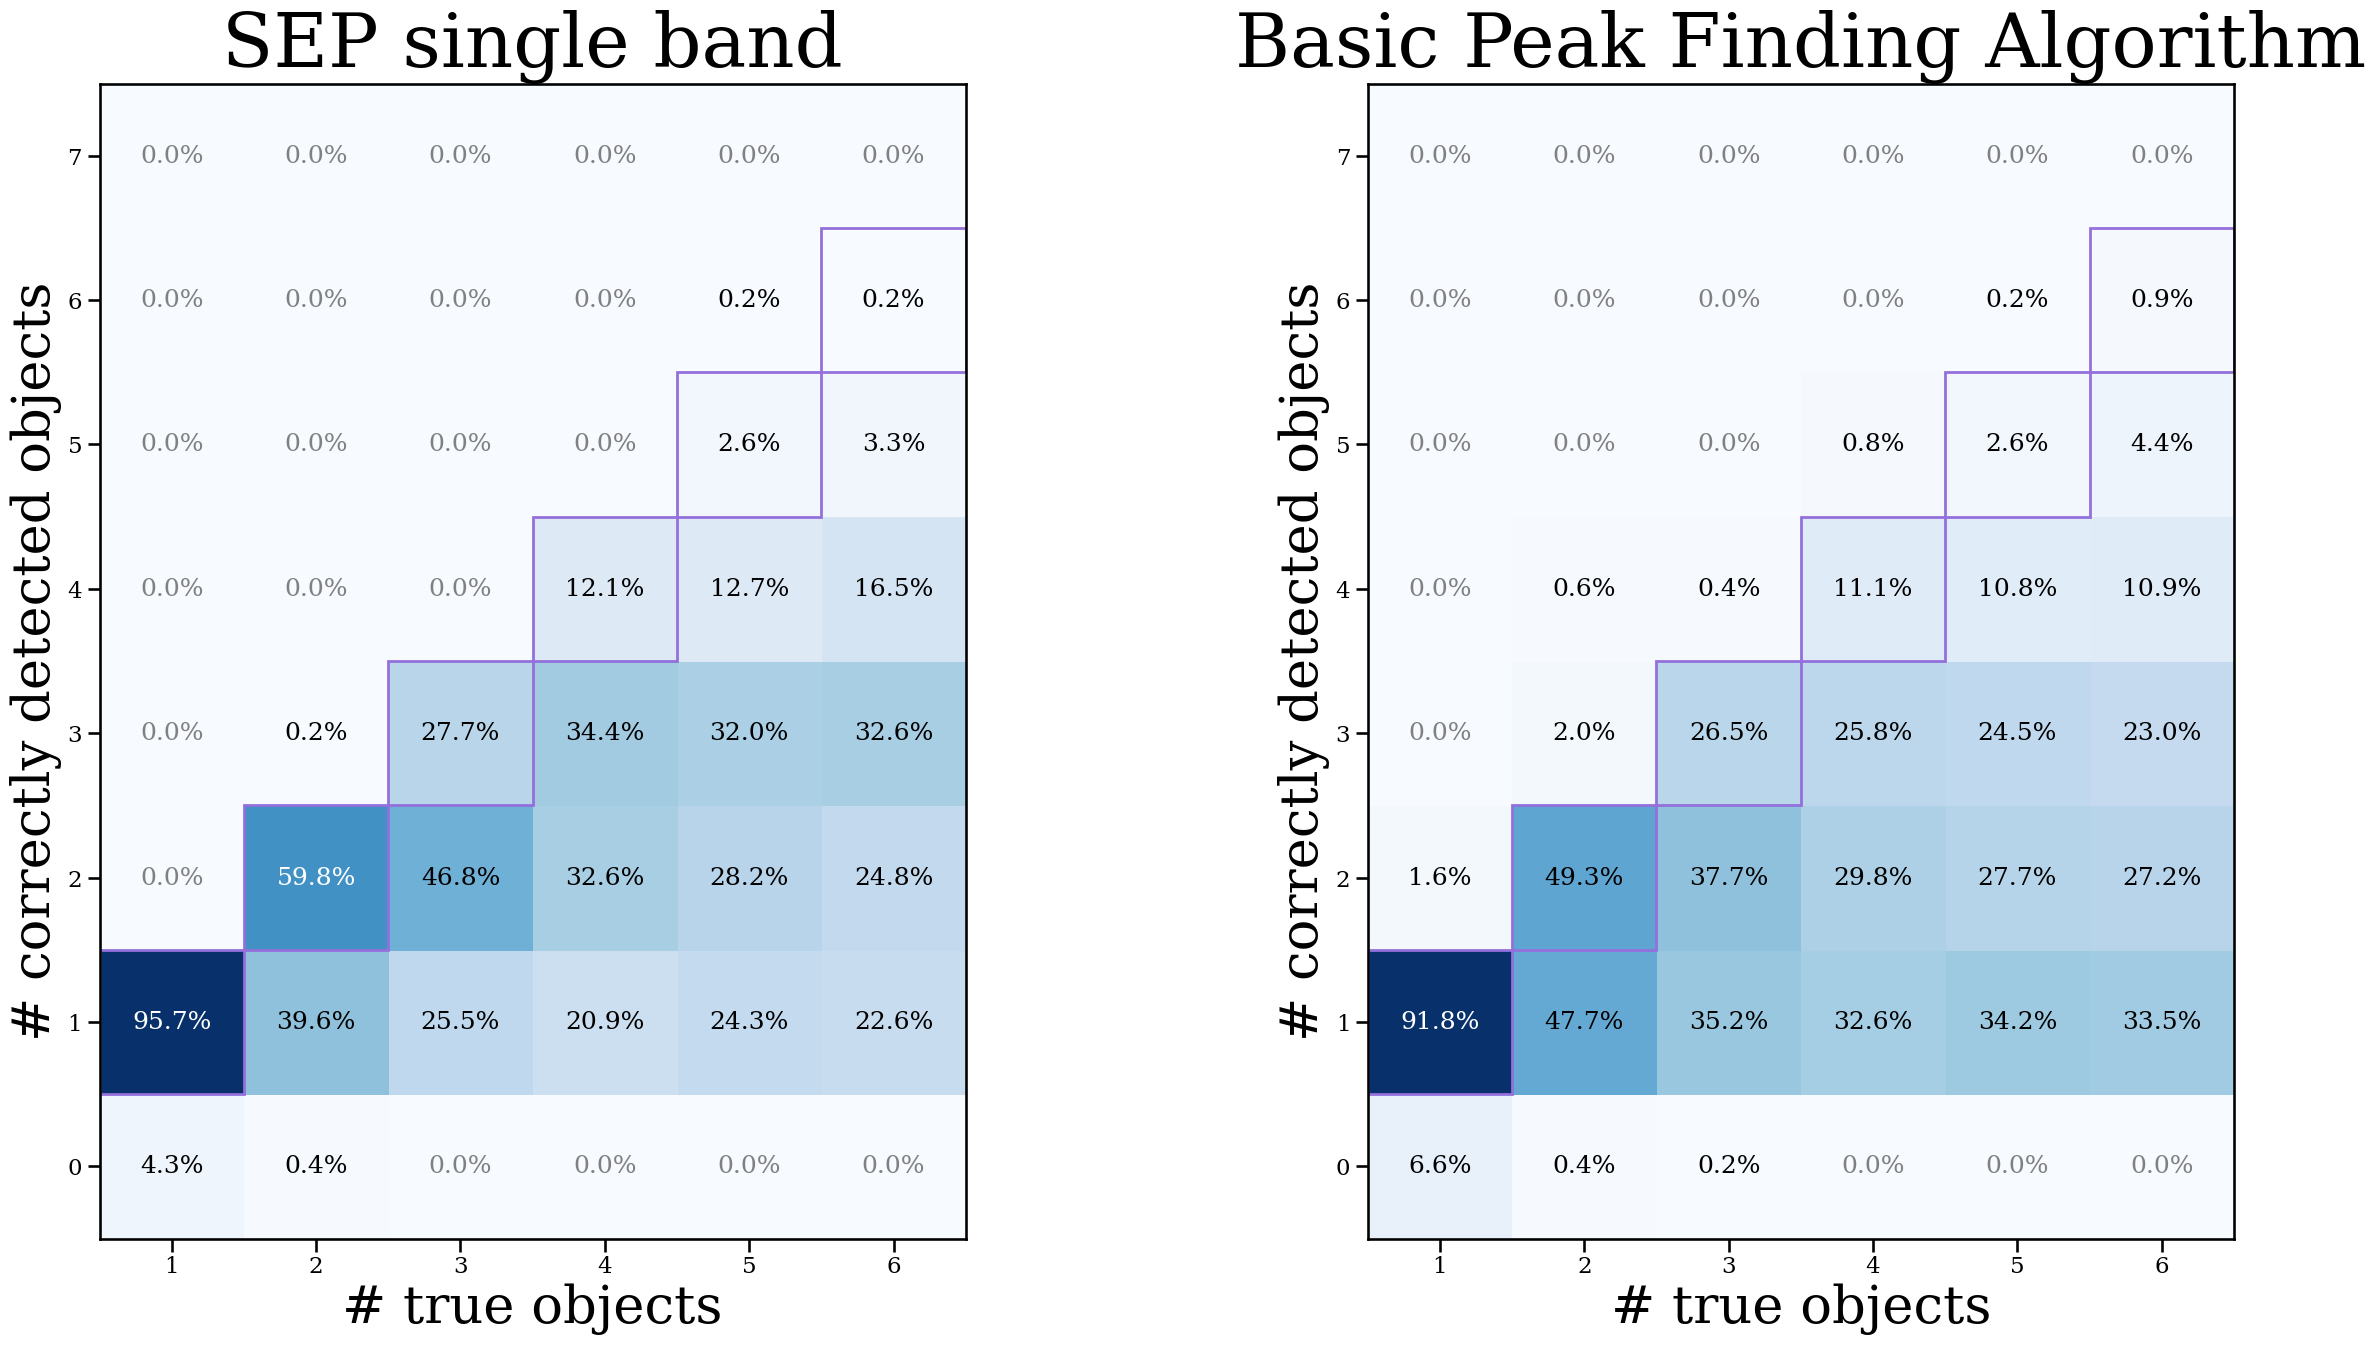

In [6]:
# List containing the more descriptive detection algorithm names
new_names = ["SEP single band", "Basic Peak Finding Algorithm"]

plot_metrics_summary(results,
                    interactive=True,
                    target_meas_keys=['ellipticity0'],
                    target_meas_limits=[(-1, 1)],
                    new_names=new_names,
                    save_path='/Users/matt/Downloads')